### 衡量预测结果的 BDBR 性能 -> VMAF

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 6)

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'serif',  # 使用衬线字体
    'font.serif': ['Times New Roman'],  # 指定 Times New Roman 字体
    'font.size': 11,
    'text.usetex': False,
    'axes.labelsize': 11,
    'axes.titlesize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 9,
    'legend.title_fontsize': 9,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.linewidth': 1,
    'axes.linewidth': 1
})
sns.set_style("whitegrid")
flierprops = dict(marker='o', markersize=2, linestyle='none')

table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
fig_dir   = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"

In [2]:
def rm_outliers(df, cols, threshold=1.5, lower_only=True):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)

        if lower_only:
            df = df[df[col] >= lower_bound]
        else:
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

In [3]:
import os
import gc
import numpy as np
from scipy.spatial import ConvexHull

cols = ["seqName", "sceneId", "regressor", "func", "input", "preset", "size", "qp", "pred_target"]
def process_group(args):
    seqName, sceneId, preset, group, regressor, inputs, func, distortion = args
    
    distortion = distortion.lower()
    assert distortion.lower() in ["psnr", "log2psnr", "ssim", "log2ssim", "vmaf", "log2vmaf"]
    is_log_distortion = ("log2" in distortion.lower())
    distortion_type   = distortion.split("log2")[-1]
     
    bitrate_df = group[
        (group["target"] == "log2bitrate") & 
        (group["regressor"] == regressor) & 
        (group["func"] == "quadratic2") &       # log2bitrate 固定使用 quadratic2
        (group["input"] == inputs)
    ][cols + ["log2bitrate", "bitrate"]].reset_index(drop=True)
    
    distortion_df = group[
        (group["target"] == distortion) & 
        (group["regressor"] == regressor) & 
        (group["func"] == func) & 
        (group["input"] == inputs)
    ][cols + [f"log2{distortion_type}", distortion_type]].reset_index(drop=True)
    
    bitrate_df    = bitrate_df.rename(columns={"pred_target": "pred_log2bitrate"})
    distortion_df = distortion_df.rename(columns={"pred_target": f"pred_{distortion}"})
    
    # 扔掉 bitrate_df 的 func -> 避免干扰 merge
    bitrate_df = bitrate_df.drop(columns=["func"])
    
    group_rd = pd.merge(distortion_df, bitrate_df, how="inner")
    group_rd["pred_bitrate"] = 2 ** group_rd["pred_log2bitrate"]
    if is_log_distortion:
        group_rd[f"pred_{distortion_type}"] = 2 ** group_rd[f"pred_{distortion}"]
    
    inputs = inputs.replace("(", "").replace(")", "")
    
    """ 1. 得到凸包 """
    points = group_rd[["bitrate", f"{distortion_type}"]].values
    actual_convex = ConvexHull(points)
    actual_hull_points = points[actual_convex.vertices]
    actual_hull_points = actual_hull_points[np.argsort(actual_hull_points[:, 0])]
    
    points = group_rd[["pred_bitrate", f"pred_{distortion_type}"]].values
    pred_convex  = ConvexHull(points)
    pred_hull_points = points[pred_convex.vertices]
    pred_hull_points = pred_hull_points[np.argsort(pred_hull_points[:, 0])]
    
    # 保存凸包所在各行
    pred_convex_df = group_rd.iloc[pred_convex.vertices].reset_index(drop=True)
    actual_convex_df = group_rd.iloc[actual_convex.vertices].reset_index(drop=True)
    pred_convex_df["convex"] = "pred"    
    actual_convex_df["convex"] = "actual"
    
    # 保存 fixed QP 对应各行 (QP = 27)
    fixed_convex_df = group_rd[group_rd["qp"] == 27].reset_index(drop=True)
    fixed_convex_df["convex"] = "fixed"
    
    os.makedirs(f"{table_dir}/BDBR/rd-{distortion}/{seqName}-scene{sceneId}", exist_ok=True)
    
    convex_df = pd.concat([pred_convex_df, actual_convex_df], axis=0)    
    convex_df = pd.concat([convex_df, fixed_convex_df], axis=0).reset_index(drop=True)
    convex_df.to_csv(f"{table_dir}/BDBR/rd-{distortion}/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.csv", index=False)
    
    """ 2. 画图 """
    fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
    sns.lineplot(ax=axes[0], data=group_rd, x="pred_bitrate", y=f"pred_{distortion_type}", hue="size", marker="o")            
    axes[0].plot(pred_hull_points[:, 0], pred_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="predicted convex hull")
    axes[0].legend()
    axes[0].set_xlabel("Predicted Bitrate (kbps)")
    ylabel = "PSNR (dB)" if distortion_type == "psnr" else distortion_type.upper()
    axes[0].set_ylabel(f"Predicted {ylabel}")
    
    sns.lineplot(ax=axes[1], data=group_rd, x="bitrate", y=distortion_type, hue="size", marker="o")
    axes[1].plot(actual_hull_points[:, 0], actual_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="actual convex hull")
    axes[1].legend()
    axes[1].set_xlabel("Actual Bitrate (kbps)")
    axes[1].set_ylabel(f"Actual {ylabel}")
    
    x_min = min(axes[0].get_xlim()[0], axes[1].get_xlim()[0])
    x_max = max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])
    y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
    y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
    
    axes[0].set_xlim(x_min, x_max)
    axes[1].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)
    axes[1].set_ylim(y_min, y_max)
    
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()
    
    os.makedirs(f"{fig_dir}/BDBR/rd-{distortion}/{seqName}-scene{sceneId}", exist_ok=True)
    plt.savefig(f"{fig_dir}/BDBR/rd-{distortion}/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.pdf", format="pdf")
    plt.close("all")
    gc.collect()

#### 1. 预测的是 log2vmaf

In [4]:
import pandas as pd

pred_df = pd.read_csv(f"{table_dir}/predCurve/combined_preds.csv")
pred_df = pred_df.drop(columns=["p1", "p2", "p3", "pred_p1", "pred_p2", "pred_p3"])     # 不用看参数了

display(pred_df)
print(pred_df.columns.tolist())

,seqName,sceneId,regressor,input,preset,size,func,target,qp,pred_target,bitrate,log2bitrate,psnr,log2psnr,ssim,log2ssim,vmaf,log2vmaf,err
0,Lecture-42c3,0,Adam,(faster)x(360P),faster,1080P,linear,bitrate,22,675.249878,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,363.210522
1,Lecture-42c3,0,Adam,(medium)x(360P),faster,1080P,linear,bitrate,22,695.509933,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,342.950467
2,Lecture-42c3,0,Adam,(slower)x(360P),faster,1080P,linear,bitrate,22,1486.697418,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,-448.237018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257789,Lecture-7e40,1,SGDRegressor,(faster)x(1080P),slower,720P,quadratic3,log2vmaf,52,6.092571,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.104890
4257790,Lecture-7e40,1,SGDRegressor,(medium)x(1080P),slower,720P,quadratic3,log2vmaf,52,6.029500,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.167961
4257791,Lecture-7e40,1,SGDRegressor,(slower)x(1080P),slower,720P,quadratic3,log2vmaf,52,5.804019,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.393442


['seqName', 'sceneId', 'regressor', 'input', 'preset', 'size', 'func', 'target', 'qp', 'pred_target', 'bitrate', 'log2bitrate', 'psnr', 'log2psnr', 'ssim', 'log2ssim', 'vmaf', 'log2vmaf', 'err']


In [5]:
""" 计算所有序列的 RD 性能 """
grouped = pred_df.groupby(["seqName", "sceneId", "preset"], as_index=False)

from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

tasks = []
verbose = True
for (seqName, sceneId, preset), group in tqdm(grouped):
    for regressor in group["regressor"].unique():
        for func in group["func"].unique():
            for inputs in group["input"].unique():
                tasks.append((seqName, sceneId, preset, group, regressor, inputs, func, "log2vmaf"))
                verbose = False

with ProcessPoolExecutor() as executor:
    executor.map(process_group, tasks)

100%|██████████| 66/66 [00:05<00:00, 11.48it/s]


In [6]:
""" 把每个序列所有的 dataframe 叠在一起 """
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/BDBR/rd-log2vmaf")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/BDBR/rd-log2vmaf/{seq}")):
        convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/BDBR/rd-log2vmaf/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True) 
display(convex_df)

convex_df.to_csv(f"{table_dir}/BDBR/convex_log2vmaf.csv", index=False)

100%|██████████| 864/864 [00:22<00:00, 38.23it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_log2vmaf,log2vmaf,vmaf,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,pred_vmaf,convex
0,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,1080P,22,6.445319,6.609370,97.637913,12.506482,12.602524,6219.2459,5818.701542,87.143398,pred
1,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,540P,22,6.758271,6.608287,97.564672,10.724766,11.567760,3035.5865,1692.295312,108.253579,pred
2,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,360P,22,6.728930,6.599837,96.994878,9.470541,10.614585,1567.8646,709.442206,106.074223,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440165,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,27,6.663819,6.606134,97.419187,9.196966,9.594119,772.8900,586.898086,101.393325,fixed
440166,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,540P,27,6.630093,6.616077,98.092921,10.404303,10.338697,1294.9650,1355.211758,99.050539,fixed
440167,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,720P,27,6.639444,6.622750,98.547686,11.381953,10.785714,1765.3200,2668.758535,99.694660,fixed


In [7]:
""" 计算 BDBR -> 1) 相较于传统 CAE (会有 loss);  2) 相较于 fixed QP (会有 gain) """
from fastCAE.metrics.bjontegaard import BD_PSNR, BD_RATE
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 8)

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])
rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    fixed_convex_df  = group[group["convex"] == "fixed"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_vmaf_cae = BD_PSNR(
        actual_convex_df["bitrate"].tolist(), actual_convex_df["vmaf"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["vmaf"].tolist(), piecewise=0
    )
    bd_vmaf_fix = BD_PSNR(
        fixed_convex_df["bitrate"].tolist(), fixed_convex_df["vmaf"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["vmaf"].tolist(), piecewise=0
    )
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_vmaf_cae, "cae"])
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_vmaf_fix, "fixed"])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_vmaf", "anchor"])
all_bdbr = rm_outliers(all_bdbr, cols=["bd_vmaf"], threshold=0.75)
display(all_bdbr)
display(all_bdbr.describe())                  

all_bdbr.to_csv(f"{table_dir}/BDBR/all_rd_log2vmaf.csv", index=False)

19008it [00:40, 467.73it/s]


,seqName,sceneId,regressor,func,input,preset,bd_vmaf,anchor
1,Lecture-42c3,0,Adam,linear,(faster)x(1080P),faster,1.500250,fixed
2,Lecture-42c3,0,Adam,linear,(faster)x(1080P),medium,-1.766953,cae
3,Lecture-42c3,0,Adam,linear,(faster)x(1080P),medium,1.584672,fixed
4,Lecture-42c3,0,Adam,linear,(faster)x(1080P),slower,-3.914846,cae
...,...,...,...,...,...,...,...,...
38012,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),medium,-0.307391,cae
38013,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),medium,-0.474133,fixed
38014,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),slower,-0.139537,cae
38015,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),slower,-0.091173,fixed


,sceneId,bd_vmaf
count,34168.000000,34168.000000
mean,3.315500,0.703788
std,3.488421,2.645647
min,0.000000,-3.975915
25%,1.000000,-0.919318
50%,2.000000,0.530666
75%,6.000000,1.942323
max,11.000000,116.150621


In [8]:
# 看一下不同预测策略 (regressor, func, input) 的效果
table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
all_bdbr = pd.read_csv(f"{table_dir}/BDBR/all_rd_log2vmaf.csv")

grouped = all_bdbr.groupby(["anchor", "regressor", "func", "input"], as_index=False)

rows = []
for (anchor, regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_vmaf"].mean(), anchor])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_vmaf", "anchor"])
avg_bdbr = rm_outliers(avg_bdbr, cols=["bd_vmaf"], threshold=0.75).reset_index(drop=True)
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/BDBR/avg_rd_log2vmaf.csv", index=False)

,regressor,func,input,bd_vmaf,anchor
0,Adam,linear,(faster)x(1080P),-1.096717,cae
1,Adam,linear,(faster)x(360P),-1.394773,cae
2,Adam,linear,(faster)x(540P),-1.074033,cae
3,Adam,linear,(faster)x(720P),-1.244358,cae
...,...,...,...,...,...
570,SGDRegressor,quadratic3,(slower)x(1080P),2.631574,fixed
571,SGDRegressor,quadratic3,(slower)x(360P),0.784090,fixed
572,SGDRegressor,quadratic3,(slower)x(540P),2.385406,fixed
573,SGDRegressor,quadratic3,(slower)x(720P),2.121236,fixed


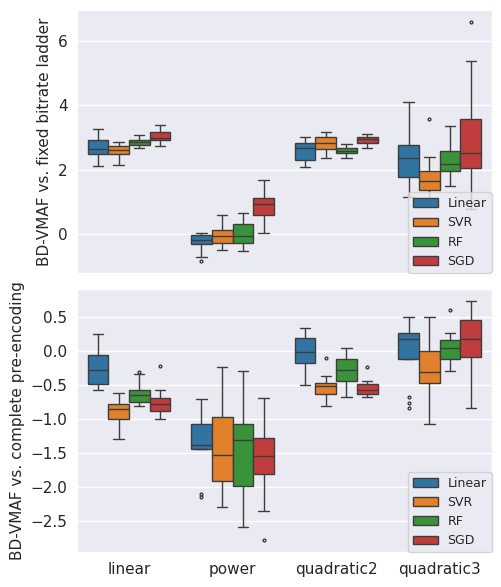

In [15]:
# 直观看一下区别
label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}

# 画一下 BD-Rate (左边是相比 fixed QP 的, 右边是相比 traditional CAE 的)
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

sns.boxplot(
    ax=axes[0], data=avg_bdbr[(avg_bdbr["anchor"] == "fixed") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_vmaf", hue="regressor", flierprops=flierprops)
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[0].set_xlabel("")
axes[0].set_ylabel("BD-VMAF vs. fixed bitrate ladder")
axes[0].legend(handles, new_labels, borderaxespad=0., loc="lower right")

sns.boxplot(ax=axes[1], data=avg_bdbr[(avg_bdbr["bd_vmaf"] < 1) & (avg_bdbr["anchor"] == "cae") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_vmaf", hue="regressor", flierprops=flierprops)
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[1].set_xlabel("")
axes[1].set_ylabel("BD-VMAF vs. complete pre-encoding")
axes[1].legend(handles, new_labels, borderaxespad=0., loc="lower right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/BDBR/bd_vmaf_log2vmaf.pdf", format="pdf")

#### 2. 预测的是 vmaf

In [16]:
import pandas as pd

pred_df = pd.read_csv(f"{table_dir}/predCurve/combined_preds.csv")
pred_df = pred_df.drop(columns=["p1", "p2", "p3", "pred_p1", "pred_p2", "pred_p3"])     # 不用看参数了

display(pred_df)
print(pred_df.columns.tolist())

,seqName,sceneId,regressor,input,preset,size,func,target,qp,pred_target,bitrate,log2bitrate,psnr,log2psnr,ssim,log2ssim,vmaf,log2vmaf,err
0,Lecture-42c3,0,Adam,(faster)x(360P),faster,1080P,linear,bitrate,22,675.249878,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,363.210522
1,Lecture-42c3,0,Adam,(medium)x(360P),faster,1080P,linear,bitrate,22,695.509933,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,342.950467
2,Lecture-42c3,0,Adam,(slower)x(360P),faster,1080P,linear,bitrate,22,1486.697418,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,-448.237018
3,Lecture-42c3,0,Adam,(faster)x(540P),faster,1080P,linear,bitrate,22,1049.840759,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,-11.380359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257788,Lecture-7e40,1,SGDRegressor,(slower)x(720P),slower,720P,quadratic3,log2vmaf,52,6.218592,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,-0.021131
4257789,Lecture-7e40,1,SGDRegressor,(faster)x(1080P),slower,720P,quadratic3,log2vmaf,52,6.092571,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.104890
4257790,Lecture-7e40,1,SGDRegressor,(medium)x(1080P),slower,720P,quadratic3,log2vmaf,52,6.029500,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.167961
4257791,Lecture-7e40,1,SGDRegressor,(slower)x(1080P),slower,720P,quadratic3,log2vmaf,52,5.804019,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.393442


['seqName', 'sceneId', 'regressor', 'input', 'preset', 'size', 'func', 'target', 'qp', 'pred_target', 'bitrate', 'log2bitrate', 'psnr', 'log2psnr', 'ssim', 'log2ssim', 'vmaf', 'log2vmaf', 'err']


In [17]:
""" 计算所有序列的 RD 性能 """
grouped = pred_df.groupby(["seqName", "sceneId", "preset"], as_index=False)

from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

tasks = []
verbose = True
for (seqName, sceneId, preset), group in tqdm(grouped):
    for regressor in group["regressor"].unique():
        for func in group["func"].unique():
            for inputs in group["input"].unique():
                tasks.append((seqName, sceneId, preset, group, regressor, inputs, func, "vmaf"))
                verbose = False

with ProcessPoolExecutor() as executor:
    executor.map(process_group, tasks)

100%|██████████| 66/66 [00:05<00:00, 11.30it/s]


In [18]:
""" 把每个序列所有的 dataframe 叠在一起 """
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/BDBR/rd-vmaf")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/BDBR/rd-vmaf/{seq}")):
        convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/BDBR/rd-vmaf/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True) 
display(convex_df)

convex_df.to_csv(f"{table_dir}/BDBR/convex_vmaf.csv", index=False)

100%|██████████| 864/864 [00:23<00:00, 37.21it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_vmaf,log2vmaf,vmaf,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,convex
0,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,720P,52,44.758430,6.166230,71.815851,4.420590,5.202332,36.8178,21.415596,pred
1,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,1080P,22,56.061935,6.609370,97.637913,12.506482,12.602524,6219.2459,5818.701542,pred
2,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,360P,22,103.798292,6.599837,96.994878,9.470541,10.614585,1567.8646,709.442206,pred
3,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,360P,27,98.138602,6.558610,94.262384,8.831721,8.990679,508.7028,455.630703,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446316,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,1080P,27,95.182008,6.625269,98.719918,12.309439,11.424922,2749.4400,5075.867354,fixed
446317,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,27,97.826640,6.606134,97.419187,9.196966,9.594119,772.8900,586.898086,fixed
446318,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,540P,27,97.050240,6.616077,98.092921,10.404303,10.338697,1294.9650,1355.211758,fixed
446319,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,720P,27,96.129119,6.622750,98.547686,11.381953,10.785714,1765.3200,2668.758535,fixed


In [19]:
""" 计算 BDBR -> 1) 相较于传统 CAE (会有 loss);  2) 相较于 fixed QP (会有 gain) """
from fastCAE.metrics.bjontegaard import BD_PSNR, BD_RATE
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 8)

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])
rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    fixed_convex_df  = group[group["convex"] == "fixed"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_vmaf_cae = BD_PSNR(
        actual_convex_df["bitrate"].tolist(), actual_convex_df["vmaf"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["vmaf"].tolist(), piecewise=0
    )
    bd_vmaf_fix = BD_PSNR(
        fixed_convex_df["bitrate"].tolist(), fixed_convex_df["vmaf"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["vmaf"].tolist(), piecewise=0
    )
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_vmaf_cae, "cae"])
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_vmaf_fix, "fixed"])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_vmaf", "anchor"])
all_bdbr = rm_outliers(all_bdbr, cols=["bd_vmaf"], threshold=0.75)
display(all_bdbr)
display(all_bdbr.describe())                  

all_bdbr.to_csv(f"{table_dir}/BDBR/all_rd_vmaf.csv", index=False)

19008it [00:41, 455.34it/s]


,seqName,sceneId,regressor,func,input,preset,bd_vmaf,anchor
1,Lecture-42c3,0,Adam,linear,(faster)x(1080P),faster,4.429433,fixed
2,Lecture-42c3,0,Adam,linear,(faster)x(1080P),medium,-2.419623,cae
3,Lecture-42c3,0,Adam,linear,(faster)x(1080P),medium,2.030693,fixed
4,Lecture-42c3,0,Adam,linear,(faster)x(1080P),slower,-2.813918,cae
...,...,...,...,...,...,...,...,...
38012,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),medium,-0.567758,cae
38013,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),medium,2.490365,fixed
38014,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),slower,0.038703,cae
38015,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),slower,4.435296,fixed


,sceneId,bd_vmaf
count,33781.000000,33781.000000
mean,3.373168,0.975432
std,3.497186,24.714388
min,0.000000,-3.668229
25%,1.000000,-0.698248
50%,2.000000,0.546381
75%,6.000000,1.907064
max,11.000000,3869.520350


In [20]:
# 看一下不同预测策略 (regressor, func, input) 的效果
table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
all_bdbr = pd.read_csv(f"{table_dir}/BDBR/all_rd_vmaf.csv")

grouped = all_bdbr.groupby(["anchor", "regressor", "func", "input"], as_index=False)

rows = []
for (anchor, regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_vmaf"].mean(), anchor])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_vmaf", "anchor"])
avg_bdbr = rm_outliers(avg_bdbr, cols=["bd_vmaf"], threshold=0.75).reset_index(drop=True)
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/BDBR/avg_rd_vmaf.csv", index=False)

,regressor,func,input,bd_vmaf,anchor
0,Adam,linear,(faster)x(1080P),-0.602229,cae
1,Adam,linear,(faster)x(360P),-1.499045,cae
2,Adam,linear,(faster)x(540P),-0.560654,cae
3,Adam,linear,(faster)x(720P),-1.032829,cae
...,...,...,...,...,...
557,SGDRegressor,quadratic3,(slower)x(1080P),6.586540,fixed
558,SGDRegressor,quadratic3,(slower)x(360P),2.125142,fixed
559,SGDRegressor,quadratic3,(slower)x(540P),4.632889,fixed
560,SGDRegressor,quadratic3,(slower)x(720P),4.748610,fixed


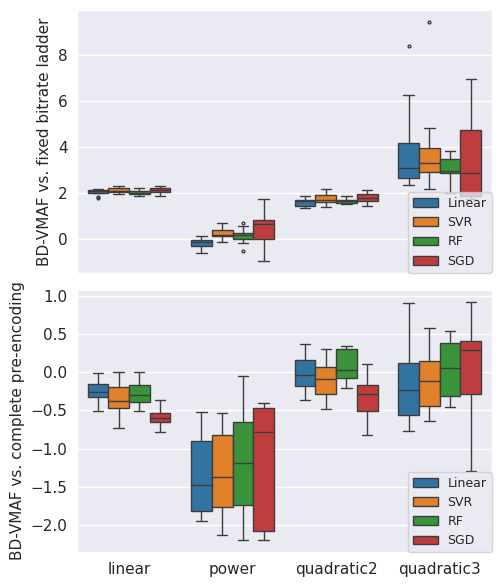

In [22]:
# 直观看一下区别
label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}

# 画一下 BD-Rate (左边是相比 fixed QP 的, 右边是相比 traditional CAE 的)
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

sns.boxplot(
    ax=axes[0], data=avg_bdbr[(avg_bdbr["bd_vmaf"] < 10) & (avg_bdbr["anchor"] == "fixed") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_vmaf", hue="regressor", flierprops=flierprops)
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[0].set_xlabel("")
axes[0].set_ylabel("BD-VMAF vs. fixed bitrate ladder")
axes[0].legend(handles, new_labels, borderaxespad=0., loc="lower right")

sns.boxplot(ax=axes[1], data=avg_bdbr[(avg_bdbr["bd_vmaf"] < 1) & (avg_bdbr["anchor"] == "cae") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_vmaf", hue="regressor", flierprops=flierprops)
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[1].set_xlabel("")
axes[1].set_ylabel("BD-VMAF vs. complete pre-encoding")
axes[1].legend(handles, new_labels, borderaxespad=0., loc="lower right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/BDBR/bd_vmaf_vmaf.pdf", format="pdf")